# Локализация в PSLG методом полос
   Воспользуемся следующей идей: сначала локализуемся по координате $x$, а затем по координате $y$. Для этого через каждую точку $PSLG$ проведем прямую. В итоге мы разбили всю плоскость на полосы.

![Пример разбиения плоскости](images/SLABS.png)

   Теперь отсортируем полосы по координате $x$. Это позволит нам с помощью двоичного поиска за $O(\log{n})$ найти полосу, в которую попала точка запроса. Заметим, что по построению ребра могут пересекаться только на границах полос. Следовательно внутри одной полосы ребра вертикально упорядочены. Значит мы можем хранить для каждой полосы, например, дерево поиска и за $O(\log{n})$ локализоваться в ней.
   
   Рассмотрим локализацию в полосе несколько подробнее. Задача состоит в том, чтобы определить какое ребро выше, а какое ниже точки запроса(зная это можно однозначно определить какому фейсу принадлежит точка).
   
### Упражнение
   Вам необходимо реализовать алгоритм локализации в полосе. Для этого вам необходимо реализовать функцию <b>locate</b>. Он принимает два аргумента:

* <b>point</b> $-$ точка запроса(точка представляет из себя список из двух элементов $-$ координаты $x$ и координаты $y$)
* <b>edges</b> $-$ список ребер, где каждое ребро $-$ это список из двух точек

Вы можете пользоваться методом <b>turn(a, b, c)</b> из <b>test_utils</b>, который считает поворот точки $c$ относительно отрезка $ab$ и возвразвращает:

* $-1$, если поворот левый
* $0$ , если они лежат на одной прямой
* $1$ , если поворот правый

Функция должна возвращать кортеж из двух индексов: индекса ребра снизу и сверху.

Это интерактивная модель, поэтому Вы можете проверить корректность решения, просто сделав несколько кликов внутри полосы.

<IPython.core.display.Javascript object>


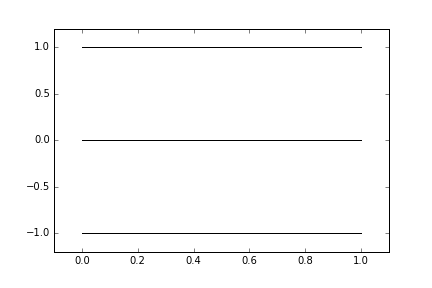

Figure(432x288)


In [53]:
%matplotlib notebook
from test_utils import *

slab = Slab.read_slab("sample01.txt")
c = 0
fig = slab.fig

ax = slab.ax

def locate(point, edges):
    # Сейчас тут стоит заглушка, чтобы не отрисовывать никакой фейс
    return None

def on_click(event):
    # Функция для обработки нажатия.
    # Лучше не меняйте, чтобы не сломать интерактивность.
#     slab.fig.canvas.disconnect(cib)
    c += 1
    point = [event.xdata, event.ydata]
    print("click: ", point)
    slab.redraw(locate(slab.edges, point), point)
    fig = slab.fig
    
fig.canvas.mpl_connect('button_release_event', on_click)
slab.draw()

   Теперь немного поговорим об особенностях реализации данного алгоритма. Что мы вообще делаем: в какие-то полосы мы добавляем отрезок, а в каких-то мы его удаляем. Следовательно для одного отрезка(ребра) у нас есть события двух типов:

* <b>insert</b>, когда мы его вставляем
* <b>delete</b>, когда мы уго удаляем

Рассмотрим две соседние полосы. Заметим, что полоса справа отличается от полосы слева тем, что в ней были удалены или добавлены какие-то отрезки. Тогда заведем приоритетную очередь, в которую положим все эти события(так как событие происходит в какой-то точке, то сравнивать события мы будем, как точки в которых они происходят). Следовательно алгоритм становится следующим: добавим все события в приоритетную очередь, будем по очереди доставать события и выполнять их. При этом понятно, что если $x$ координата события не совпадает с $x$ координатой текущей полосы, то это событие уже относится к новой полосе.

В следующей ячейке следует возможная реализация алгоритма построения локализационный структуры.

In [3]:
import heapq
from enum import Enum
from sortedcontainers import SortedSet


class Segment:
    def __init__(self, a, b):
        self.origin = a
        self.destination = b
        if self.destination < self.origin:
            self.origin, self.destination = self.destination, self.origin

    def __lt__(self, other):
        if self.origin < other.origin:
            return True
        elif self.origin > other.origin:
            return False

        temp = turn(self.origin, self.destination, other.distination)

        if temp == -1:
            return True
        elif temp == 1:
            return False
        else:
            return self.destination < other.distination


class Event:

    class EventType(Enum):
        INSERT = 1
        DELETE = 2

    def __init__(self, point, segment: Segment, insert: EventType):
        self.x, self.y = point
        self.edge = segment
        self.insert = insert


def createSearchingDataStructure(edges: list):

    currentSlab = SortedSet()
    events = list()
    slabs = list()

    for e in edges:
        events.append(Event(e.origin, e, Event.EventType.INSERT))
        events.append(Event(e.destination, e, Event.EventType.DELETE))

    while len(events) != 0:
        event = heapq.heappop(events)

        if len(slabs) == 0 or (event.x, currentSlab) != slabs[-1]:
            currentSlab = currentSlab.copy()
            slabs.append((event.x, currentSlab))

        if event.type == Event.EventType.INSERT:
            currentSlab.add(event.edge)
        elif event.type == Event.EventType.DELETE:
            currentSlab.remove(event.edge)
        else:
            raise Exception('Unknown event type')
    return slabs


   Отлично! Мы получили работающий алгоритм, но у него есть недостаток: он использует $O(n^2)$ памяти в худшем случае. Теперь мы будем немного модифицировать данный алгоритм, чтобы уменьшить потребление памяти.

## Персистентные деревья

   Для того чтобы улучшить использование памяти нам понадобятся персистентные деревья поиска.
   
   Давайте рассмотрим $x$ - координату как время. Двигаясь вправо по $x$, мы движемся во времени. Пусть у нас есть изначально пустое дерево поиска. Когда мы встречаем начало отрезка, мы добавляем его в дерево с текущей $y$ - координатой. Когда мы встречаем конец отрезка, удаляем его из дерева (если отрезок(ки) лежит(ат) на вертикальной прямой, события начала/конца сортируются по y, а если один отрезок заканчивается, а другой начинается в одной и той же точке, событие начала идет раньше).
   
   Вернемся к первоначальной задаче. Применем к полосам метафору времени: одна полоса - это отрезок времени, когда ничего не происходило. То есть, на одну полосу приходится одна версия персистентного дерева (а не отдельное дерево поиска, как раньше). С точки зрения операции поиска ничего не изменилось(теперь мы просто ищем по координате $x$ версию дерева поиска, а дальше наш алгоритм не изменился). 
   А вот потребление памяти уменьшилось до $O(n\log{n})$ - так как в персистентном дереве при операции добавления/удаления прибавляется $O(\log{n})$ памяти (копируются узлы на пути от корня до вставленной/удаленной вершины + $O(1)$ на перебалансировку), а так как отрезков $O(n)$, то всего таких операций будет тоже $O(n)$.

## Частично персистентные деревья

   Оказывается, что использование памяти можно свести к $O(n)$.
   Используем тот факт, что нам не нужна полная персистентность (возможность менять и читать все версии). Нам достаточно только частичной (возможность менять и получать новые версии только из последней, но делать запросы можно по всем). Чтобы понять идею, попробуем сначала сделать что-нибудь попроще, но такое же модное - частично персистентный список, например.
   
   Давайте в узле списка хранить не один указатель на следующий элемент, а $2$ - $next$ и $next2$. Дополнительно мы будем хранить номер первой версии списка, начиная с которой используется указатель $next2$. Также мы будем поддерживать таблицу (хэшмап или массив), с помощью которого по версии будем получать указатель на начало списка.

   Пусть мы хотим вставить очередной элемент в такой список между элементами $i$ и $i + 1$ – создать новую версию под номером k. Мы начинаем идти от корня, соответствующего версии $k − 1$ до элемента $i$. Всякий раз мы выбираем соответствующий самой свежей версии указатель из двух (это всегда будет $next2$, если он не $null$). Пусть мы дошли до $i$ -го узла. Если его указатель $next2$ пуст, мы создаем новую вершину, указатель $next$ которой мы подвешиваем на $i + 1$, а указатель $i.next2$ подвешиваем к новой вершине. В противном случае нам придется скопировать $i$ и всех его предков до тех пор, пока мы не встретим предка со свободным указателем $next2$.

   Такую же тактику применим в деревьях: добавим в каждый узел дерева по дополнительному указателю $next$ и номер версии + флажок направления: влево или вправо смотрит $next$. Балансировочную информацию (размер поддерева или там цвет вершины) в вершине мы будем нещадно перезаписывать, потому что эта информация может быть актуальна только для последней версии (все предыдущие версии дерева сбалансированны).
   
<b>Утверждение</b><br>
> Вышеописанное частично персистентное дерево использует $O(n)$ памяти<br>

$\triangleright$
   
   В худшем случае, конечно же, нам придется копировать $O(\log{n})$ узлов, но мы самортизируем эту оценку.
   <br>
   Заметим, что копируем мы только те узлы, в которых уже занят указатель $next$. Давайте будем платить $2$ монетки за обновление указателя $next$ и версии в узле: одну за саму операцию, а другую отложим в узел про запас. Таким образом, в каждом заполненном узле будет лежать запасенная монетка. Когда нам нужно будет скопировать этот узел, мы потратим только уже отложенные монетки.
Таким образом, амортизированная оценка для дополнительной памяти на операцию изменения в дереве – $O(1)$, а так как операций изменения $O(n)$, то и памяти всего требуется $O(n)$.

$\triangleleft$